In [ ]:
import os
import pickle
import json
import matplotlib.pyplot as plt
import argparse
import itertools

from tensorboardX import SummaryWriter
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml
from bisect import bisect
import numpy as np

from visdialch.data.dataset import VisDialDataset
from visdialch.encoders import Encoder
from visdialch.decoders import Decoder
from visdialch.metrics import SparseGTMetrics, NDCG
from visdialch.model import EncoderDecoderModel
from visdialch.utils.checkpointing import CheckpointManager, load_checkpoint

import datetime
import os
import pickle

In [271]:
with open('checkpoints/2019-06-27T19:03:26.880078/testbatch_3.pkl', 'rb') as file:
    batch_dict, attention = pickle.load(file)

In [236]:
# =============================================================================
#   SETUP DATASET, DATALOADER, MODEL, CRITERION, OPTIMIZER, SCHEDULER
# =============================================================================
config = yaml.load(open('configs/lf_disc_faster_rcnn_x101.light.newfeatures.yml'))
train_dataset = VisDialDataset(
    config["dataset"],
    "data/visdial_1.0_train.json",
    overfit=10,
    in_memory=False,
    return_options=True if config["model"]["decoder"] == "disc" else False,
    add_boundary_toks=False if config["model"]["decoder"] == "disc" else True,
)
print('Length of train dataset:', len(train_dataset))
n_batches_per_epoch = int(np.ceil(len(train_dataset) / config["solver"]["batch_size"]))

/usr/cs/public/project_vis/visdialciss/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [237]:
import re
from PIL import Image

In [36]:
available_image_ids = {
    float(re.findall(r'([\d]+)\.jpg', f)[0])
    :
    os.path.join(f'../visdial-challenge-starter-pytorch/data/images/{split}/{f}')
    for split in (
        'train2014',
        'test2014',
        'val2014',
        'VisualDialog_test2018',
        'VisualDialog_val2018',
    )
    for f in os.listdir(f'../visdial-challenge-starter-pytorch/data/images/{split}/')
    }
len(available_image_ids)

NameError: name 're' is not defined

In [273]:
attention.shape

(160, 64)

In [275]:
attention = attention.reshape((-1, 10, 64))

In [276]:
attention.shape, batch_dict['ques'].shape

((16, 10, 64), (16, 10, 20))

In [277]:
def ids_to_sentence(ids):
    return' '.join([
        train_dataset.vocabulary.index2word[_] 
        for _ in ids if _!=train_dataset.vocabulary.PAD_INDEX]).capitalize()

In [33]:
def get_image(img_id):
    img_path = available_image_ids.get(img_id)
    image = Image.open(img_path)
    return image

In [279]:
img = get_image(9.0)

In [280]:
def plot_attention(image, ques, attention_plot):
    temp_image = np.array(image)

    fig = plt.figure(figsize=(20, 15))
    len_result = len(ques)
    
    for l, q in enumerate(ques):
        temp_att = np.resize(attention_plot[l], (8, 8))
        title = ids_to_sentence(q)
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(title)
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [247]:
batch_dict.keys()

dict_keys(['img_ids', 'img_feat', 'ques', 'hist', 'ans_in', 'ans_out', 'ques_len', 'hist_len', 'ans_len', 'num_rounds', 'opt', 'opt_len', 'ans_ind', 'gt_relevance', 'round_id'])

In [248]:
ids_to_sentence(batch_dict['hist'][0][0])

'A woman with reflective paint under her eyes is on her hands and knees on a white surfboard floating on the water'

In [249]:
batch_dict['ans_in'][0]

array([[ 24,  69,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [304,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 42,  72, 210, 100,   5,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [304, 135,  24,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 24,  44,  34,  14,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 24,  22,  96,  14,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 10,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [194]:
for proposal in batch_dict['opt'][0]:
    print('PROPOSAL--')
    for __ in proposal:
        print(ids_to_sentence(__))

PROPOSAL--
Yes
Ca n't tell
Brown
1
Daytime
Yes , full color photo
Color
On gravel and grass
Not sure , there ’ s natural light
It 's just gray
I ca n't tell
All of them yes
Yes , it 's a full color photo
Cardboard box
Yes , just 1
Yes 1 main photo of a horse there are a few to the side but not really a main
Red , yellow , and blue
6 including the trailer
Yellow , red , and blue
There is a curtain covering it , so i am unable to tell
White
4
Silver
Yes it is in color
Yes , the image is in color
The lamps are off
There is no tv visible
Yes , the bathroom is cluttered with a number of <unk> items
Dark wood with light wood in the center
Brown and tan
No
No people
Blue
Green
I can not tell
No it 's not
Yes it 's in color
Looks like it but ca n't tell
No lake
The picture is very gray , hard to tell
It is in color
I see an image of a baseball game behind the umpire at home base
No , it is off
The mug is teal
Unable to see outside
No , just the giraffes
A little light brown
The orange
It looks

'A woman sits on a bench holding a guitar in her lap'

In [207]:
batch_dict.keys()

dict_keys(['img_ids', 'img_feat', 'ques', 'hist', 'ans_in', 'ans_out', 'ques_len', 'hist_len', 'ans_len', 'num_rounds', 'opt', 'opt_len', 'ans_ind', 'gt_relevance', 'round_id'])

In [230]:
batch_dict['hist_len']

array([[ 13,  21,  29,  36,  46,  56,  63,  77,  85,  98],
       [ 12,  25,  36,  45,  55,  71,  82,  91,  99, 110],
       [ 25,  33,  42,  57,  89, 110, 118, 126, 133, 141],
       [  9,  17,  33,  47,  56,  76,  84,  92, 100, 120],
       [ 10,  18,  26,  35,  45,  53,  59,  76,  88, 101],
       [ 10,  16,  24,  32,  44,  52,  62,  71,  80,  88],
       [ 15,  25,  33,  41,  48,  60,  72,  79,  90,  99],
       [ 29,  40,  51,  60,  69,  78,  86,  95, 102, 112],
       [ 12,  27,  37,  46,  56,  66,  77,  90, 105, 114],
       [ 10,  18,  28,  43,  51,  61,  69,  76,  84,  92]])

In [267]:
os.listdir('checkpoints/')

['.commit-412aa7d',
 '2019-06-25T20:52:38.554878',
 '2019-06-26T21:32:27.044770',
 '2019-06-26T21:43:16.856135',
 '2019-06-26T21:46:31.909863',
 '2019-06-26T21:59:17.709658',
 '2019-06-26T22:04:13.598389',
 '2019-06-26T22:07:44.819097',
 '2019-06-27T18:00:34.429271',
 '2019-06-27T18:09:25.719923',
 '2019-06-27T18:16:25.800116',
 '2019-06-27T18:26:06.929006',
 '2019-06-27T18:28:24.989364',
 '2019-06-27T18:32:36.651835',
 '2019-06-27T18:35:44.623533',
 '2019-06-27T18:41:16.608070',
 '2019-06-27T18:44:46.761118',
 '2019-06-27T18:51:29.710490',
 '2019-06-27T19:03:26.880078',
 'baseline',
 'config.yml',
 'events.out.tfevents.1561509496.dan417-11',
 'events.out.tfevents.1561509880.dan417-11',
 'no_pic_baseline',
 'sashank_baseline']

A messy cluttered bedroom with a tv on


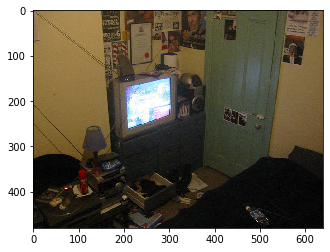

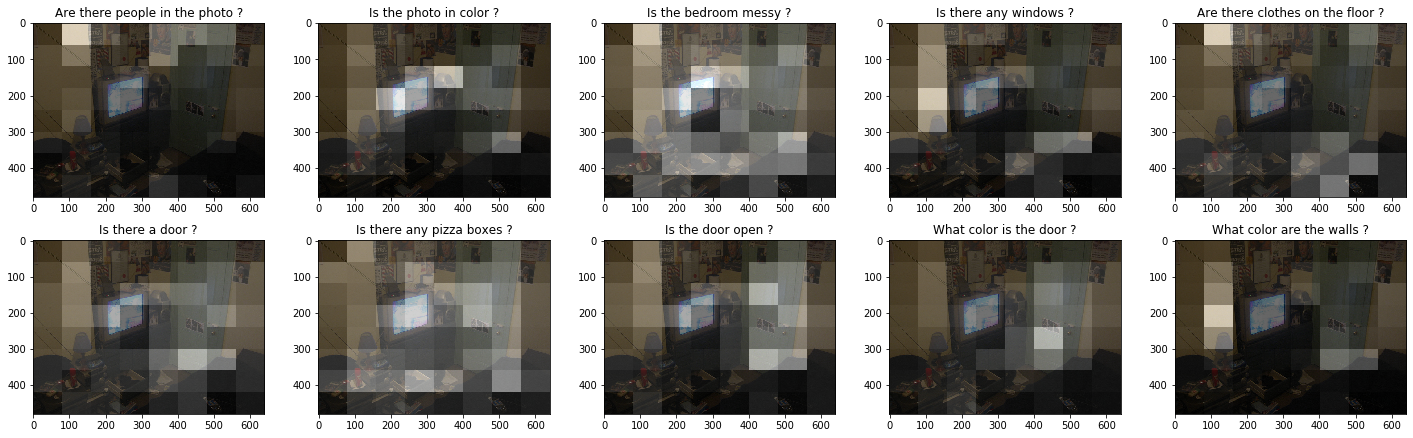

In [285]:
ix=3
print(ids_to_sentence(batch_dict['hist'][ix][0]))
plt.imshow(np.array(get_image(float(batch_dict['img_ids'][ix]))))
plot_attention(get_image(float(batch_dict['img_ids'][ix])), ques=batch_dict['ques'][ix], attention_plot=attention[ix])

In [218]:
batch_dict['hist'][0][:2, :20]

array([[   7,  589,    5,  556,   37,  285,   20, 2171,   23,    7,  525,
         292,  204,    0,    0,    0,    0,    0,    0,    0],
       [   7,  589,    5,  556,   37,  285,   20, 2171,   23,    7,  525,
         292,  204,    5,    6,   53,   15,   19,    4,   10]])

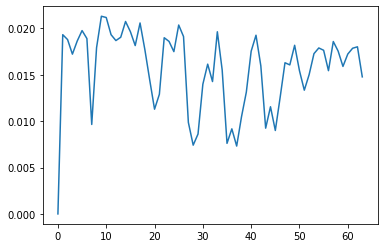

In [40]:
plt.plot(attention[11])

# Load the model 

In [6]:
import argparse
import json
import os
import re

import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml

from visdialch.data.dataset import VisDialDataset
from visdialch.encoders.lf import LateFusionEncoder as Encoder
from visdialch.decoders import Decoder
from visdialch.metrics import SparseGTMetrics, NDCG, scores_to_ranks
from visdialch.model import EncoderDecoderModel
from visdialch.utils.checkpointing import load_checkpoint

import numpy as np
from PIL import Image
from sklearn.metrics import pairwise_distances

In [7]:
available_image_ids = {
    float(re.findall(r'([\d]+)\.jpg', f)[0])
    :
    os.path.join(f'../visdial-challenge-starter-pytorch/data/images/{split}/{f}')
    for split in (
        'train2014',
        'test2014',
        'val2014',
        'VisualDialog_test2018',
        'VisualDialog_val2018',
    )
    for f in os.listdir(f'../visdial-challenge-starter-pytorch/data/images/{split}/')
    }
len(available_image_ids)

174126

In [8]:
def get_image(img_id):
    img_path = available_image_ids.get(img_id)
    image = Image.open(img_path)
    return image

In [9]:
# keys: {"dataset", "model", "solver"}
config = yaml.load(open('checkpoints/new_features_baseline/config.yml'))

/usr/cs/public/project_vis/visdialciss/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [10]:
val_dataset = VisDialDataset(
    config["dataset"],
    "data/visdial_1.0_val.json",
    "data/visdial_1.0_val_dense_annotations.json",
    return_options=True,
    add_boundary_toks=False
    if config["model"]["decoder"] == "disc"
    else True,
)

  4%|▍         | 1738/45238 [00:00<00:05, 7589.56it/s]

[val2018] Tokenizing questions...


  5%|▍         | 1600/34822 [00:00<00:02, 15991.51it/s]

[val2018] Tokenizing answers...


100%|██████████| 2064/2064 [00:00<00:00, 12964.11it/s]


[val2018] Tokenizing captions...


In [11]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size=config["solver"]["batch_size"]
    if config["model"]["decoder"] == "disc"
    else 5,
    num_workers=1,
)

In [12]:
# Pass vocabulary to construct Embedding layer.
encoder = Encoder(config["model"], val_dataset.vocabulary)
decoder = Decoder(config["model"], val_dataset.vocabulary)
print("Encoder: {}".format(config["model"]["encoder"]))
print("Decoder: {}".format(config["model"]["decoder"]))

Encoder: lf
Decoder: disc


/usr/cs/public/project_vis/visdialciss/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [13]:
model = EncoderDecoderModel(encoder, decoder)
model_state_dict, _ = load_checkpoint('checkpoints/new_features_baseline/checkpoint_10.pth')
if isinstance(model, nn.DataParallel):
    model.module.load_state_dict(model_state_dict)
else:
    model.load_state_dict(model_state_dict)
model.eval()

/usr/cs/public/project_vis/visdialciss/visdial-challenge-starter-pytorch/visdialch/utils/checkpointing.py:172: UserWarning: Current commit (18240a9) and the commit (bd60c49) at which checkpoint was saved, are different. This might affect reproducibility.
  f"Current commit ({commit_sha}) and the commit "


EncoderDecoderModel(
  (encoder): LateFusionEncoder(
    (word_embed): Embedding(11322, 300, padding_idx=0)
    (hist_rnn): DynamicRNN(
      (rnn_model): LSTM(300, 256, batch_first=True, dropout=0.5)
    )
    (ques_rnn): DynamicRNN(
      (rnn_model): LSTM(300, 256, batch_first=True, dropout=0.5)
    )
    (dropout): Dropout(p=0.5)
    (image_features_projection): Linear(in_features=2048, out_features=256, bias=True)
    (attention_proj): Linear(in_features=256, out_features=1, bias=True)
    (fusion): Linear(in_features=2560, out_features=256, bias=True)
  )
  (decoder): DiscriminativeDecoder(
    (word_embed): Embedding(11322, 300, padding_idx=0)
    (option_rnn): DynamicRNN(
      (rnn_model): LSTM(300, 256, batch_first=True, dropout=0.5)
    )
  )
)

In [9]:
import pickle

In [10]:
with open('checkpoints/new_features_baseline/testbatch_3.pkl', 'rb') as file:
    batch_dict, attention = pickle.load(file)
    batch = {
        k: torch.tensor(v) for k, v in batch_dict.items()
    }

In [17]:
predictions, attention_weights = model(batch)

In [18]:
predictions[0, 0, :]

tensor([ 0.1112,  0.0464, -0.2218,  0.3709,  0.4044,  0.1634, -0.0719, -0.0550,
        -0.0788,  0.3667,  0.1236,  0.0486, -0.1907, -0.1263,  0.2815,  0.1504,
        -0.2377, -0.1352, -0.4922,  0.0470, -0.0630, -0.2525, -0.1461,  0.1260,
        -0.2500, -0.2778, -0.0737,  0.4665,  0.1419,  0.1936,  0.1988, -0.2803,
         0.1673, -0.0057, -0.5421, -0.3642, -0.1598,  0.1810,  0.1125,  0.0732,
         0.0538,  0.2983,  0.3112,  0.2769, -0.2510,  0.1453,  0.0364,  0.2559,
        -0.1358,  0.1858,  0.0677, -0.1982, -0.0023,  0.0586,  0.0282,  0.0824,
        -0.1475, -0.2721,  0.3628,  0.4484, -0.3214, -0.0675, -0.2845,  0.0524,
         0.3638, -0.1240, -0.1829,  0.2469,  0.2860,  0.3000,  0.1491, -0.3219,
         0.0854, -0.2560,  0.0654, -0.1828, -0.2820,  0.0141, -0.1436, -0.4076,
         0.0702, -0.1834,  0.1954,  0.0274, -0.6287, -0.4950,  0.1023, -0.4609,
        -0.2224, -0.4186, -0.3469, -0.6231, -0.0365,  0.3174, -0.1790,  0.2056,
         0.1674,  0.0309, -0.4688, -0.12

In [16]:
img_ids = list()
caption_vectors = list()
captions = list()
questions = list()
questions_vectors = list()
answers = list()
questions = list()

for _ in tqdm(val_dataset):
    img_id = float(_['img_ids'].detach().numpy())
    caption_vector = (model.encoder.word_embed(_['hist'][0]).sum(0) / (_['hist'][0]!=0).sum()).detach().numpy()
    caption_str = ' '.join([item for item in val_dataset.vocabulary.to_words(_['hist'][0].detach().numpy()) if item != '<PAD>'])
    
    img_ids.append(img_id)
    caption_vectors.append(caption_vector)
    captions.append(caption_str)
    
    ques = list()
    for turn_ix in range(10):
        question_tensor = _['ques'][turn_ix]
        question_embedding = (model.encoder.word_embed(question_tensor).sum(0) / _['ques_len'][turn_ix]).detach().numpy()
        question_str = ' '.join([val_dataset.vocabulary.index2word[ix] for ix in question_tensor.detach().numpy()
                        if ix!= val_dataset.vocabulary.PAD_INDEX])
        answers_tensor = _['opt'][turn_ix].detach().numpy()
        answers_tensor_len = _['opt_len'][turn_ix].detach().numpy()
        ques.append((
            question_str,
            question_tensor.detach().numpy(),
            question_embedding,
            answers_tensor,
            answers_tensor_len
        ))
    
    questions += ques

  6%|▋         | 132/2064 [00:07<02:18, 13.92it/s]

KeyboardInterrupt: 

In [20]:
with open('data/val_data.pkl','wb') as file:
    pickle.dump((
        img_ids, caption_vectors, captions, questions, questions_vectors, answers, questions
    ), file)

In [21]:
with open('data/val_data.pkl','rb') as file:
    img_ids, caption_vectors, captions, questions, questions_vectors, answers, questions = pickle.load(file)

# Inference

In [11]:
import h5py
from nltk import word_tokenize

In [23]:
features_hdf = h5py.File('data/features_thomas_val.h5', 'r')

In [145]:
torch.cat((
    torch.zeros(1, 0, 1),
    torch.zeros(1, 10, 1)), dim=1)

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [185]:
def process(image_id, all_questions, all_answers):
    query = all_questions[-1]
    
    all_questions = all_questions+['']*(10-len(all_questions))
    all_answers = all_answers+['']*(10-len(all_answers))
    
    # Tokenizing questions, answers, and query
    all_questions_tokenized = [word_tokenize(q) for q in all_questions]
    all_questions_ids = [val_dataset.vocabulary.to_indices(q) for q in all_questions_tokenized]
    ques, ques_len = val_dataset._pad_sequences(all_questions_ids)
    
    
    all_answers_tokenized = [word_tokenize(a) for a in all_answers]
    all_answers_ids = [val_dataset.vocabulary.to_indices(a) for a in all_answers_tokenized]
    answers_ids_padded, answers_ids_lengths = val_dataset._pad_sequences(all_answers_ids)
    
    # Getting image, caption
    img_features = features_hdf["features"][list(features_hdf["image_id"]).index(image_id)]
    img_index = img_ids.index(image_id)
    caption = captions[img_index]
    caption_tokenized = word_tokenize(caption)
    caption_int = val_dataset.vocabulary.to_indices(caption_tokenized)
    
    # Getting history
    padded_history, history_lengths = val_dataset._get_history(
        caption=caption_int,
        questions=all_questions_ids,
        answers=all_answers_ids
    )
    query_tokenized = word_tokenize(query)
    query_to_ix = val_dataset.vocabulary.to_indices(query_tokenized)
    
    query_embedding = model.encoder.word_embed(torch.tensor(query_to_ix)).mean(0).detach().numpy()
    query_distances = pairwise_distances(
        [np.array(query_embedding)],
        [q[2] for q in questions], metric='cosine'
    )
    
    most_similar_question = questions[query_distances.argmin()]
    (
        question_str,
        question_numpy,
        question_embedding,
        answers_numpy,
        answers_tensor_len) = most_similar_question
    
    dict_to_model = {
        'ans':answers_ids_padded,
        'ans_len':answers_ids_lengths,
        
        'ques':ques,
        'ques_len':ques_len,
        
        'img_feat':torch.tensor(img_features),
        
        'hist':padded_history,
        'hist_len':history_lengths,
        
        'ques':ques,
        'ques_len':ques_len
        
    }
    
    
    return dict_to_model

In [169]:
with open('checkpoints/new_features_baseline/testbatch_3.pkl', 'rb') as file:
    batch_dict, attention = pickle.load(file)
    batch = {
        k: torch.tensor(v) for k, v in batch_dict.items()
    }

In [134]:
batch['round_id']

tensor([ 5,  8,  5,  1,  7,  1, 10,  5,  1,  2,  8,  7,  7,  9,  4,  4])

In [191]:
p = process(18472.0, all_answers=[''], all_questions=['are there like many waves ?'])

In [201]:
 batch['ans_out'][0]

tensor([[  50,  135,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 110,   63,   84,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   5,  495,    7, 1164,   94,   20,    6,  342,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  66,   24,   22,   14,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  22,   14,    7,  192,  210,  100,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  52,   15,    6,   59,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  21,   50,   38,   58,    5, 1205,   99,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0, 

In [194]:
p['hist']

tensor([[  7., 241.,  20.,  ...,   0.,   0.,   0.],
        [  7., 241.,  20.,  ...,   0.,   0.,   0.],
        [  7., 241.,  20.,  ...,   0.,   0.,   0.],
        ...,
        [  7., 241.,  20.,  ...,   0.,   0.,   0.],
        [  7., 241.,  20.,  ...,   0.,   0.,   0.],
        [  7., 241.,  20.,  ...,   0.,   0.,   0.]])

In [141]:
p['hist']

tensor([[  7., 241.,  20., 890.,  15.,   6.,  78.,  18.,   7.,  56.,  65.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.]])

In [184]:
batch['ques'][0]

tensor([[   5,   58,  135,   28,  361,    4,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  13,   19,    5,  100,   84,    4,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   5,   12,    7, 1164,   94,   20,    6,  342,    4,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  29,   58,   49, 1229,    4,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  22,   16,   14,    6,   74,    4,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  13,   19,    5,    6,   52,    4,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   5,   58,   15,    7,  149,    4,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  17,   39,   25, 

# JON METHOD

In [177]:
with open('data/val_data.pkl','rb') as file:
    (img_ids, caption_vectors, all_captions, all_questions, all_questions_vectors,
    all_answers, all_questions) = pickle.load(file)

In [178]:
def jon(query, questions, answers, image_id):
    index = img_ids.index(18472.0)
    caption = all_captions[index]
    
    data_dict = {
        "version":"1.0",
        "split":"test",
        "data":{
            "dialogs":[{
                'image_id':image_id,
                'dialog':[],
                'caption':caption
            }],
            "answers":[],
            "questions":[]
        }
    }
    
    query_tokenized = word_tokenize(query)
    query_to_ix = val_dataset.vocabulary.to_indices(query_tokenized)
    
    query_embedding = model.encoder.word_embed(torch.tensor(query_to_ix)).mean(0).detach().numpy()
    
    query_distances = pairwise_distances(
        [np.array(query_embedding)],
        [q[2] for q in all_questions], metric='cosine'
    )
    
    most_similar_question = all_questions[query_distances.argmin()]
    (
        question_str,
        question_numpy,
        question_embedding,
        answers_numpy,
        answers_tensor_len) = most_similar_question
    
    possible_answers_str=list()
    for a in answers_numpy:
        possible_answers_str.append(
            ' '.join([item for item in val_dataset.vocabulary.to_words(a) if item !='<PAD>']))
    
    data_dict['data']['questions'] = ['']+[query]+questions
    data_dict['data']['answers'] = ['']+answers+possible_answers_str
    
    # history
    for e, (q, a) in enumerate(zip(questions, answers)):
        data_dict['data']['dialogs'][0]['dialog'].append({
            'answer':e+1,
            'question':2+e,
            'answer_options':list(range(
                len(data_dict['data']['answers'])-100,
                len(data_dict['data']['answers']))
            ),
            'gt_index':0
        })
    data_dict['data']['dialogs'][0]['dialog'].append({
        'answer':0,
        'question':1,
        'answer_options':list(range(
                len(data_dict['data']['answers'])-100,
                len(data_dict['data']['answers']))
            ),
        'gt_index':0
    })
    
    dialogue_len=len(data_dict['data']['dialogs'][0]['dialog'])
    #for pad in range(0, 10-dialogue_len):
    #    data_dict['data']['dialogs'][0]['dialog'].append({
    #        'answer':0,
    #        'question':0,
    #        'answer_options':list(range(
    #                len(data_dict['data']['answers'])-100,
    #                len(data_dict['data']['answers']))
    #            )
    #    })
    return data_dict

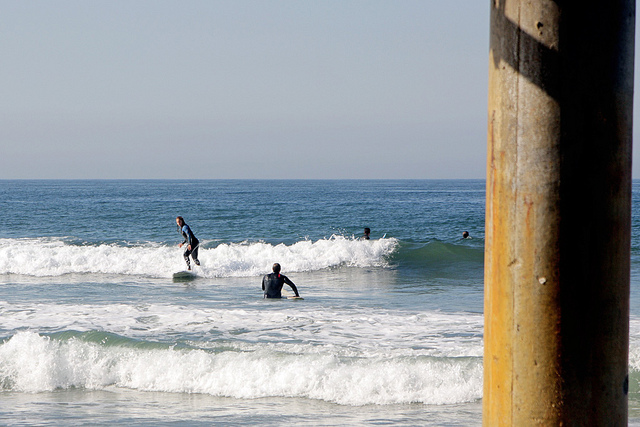

In [179]:
get_image(18472.0)

In [214]:
J = jon(query='can you see a horse?', answers=list(), questions=list(),image_id=18472.0)

In [215]:
import json
with open('/tmp/J.json','w') as file:
    json.dump(J, file)

In [216]:
config['dataset']['image_features_train_h5']='data/features_thomas_val.h5'
config['dataset']['image_features_test_h5']='data/features_thomas_val.h5'
config['dataset']['image_features_val_h5']='data/features_thomas_val.h5'

In [217]:
config['dataset']

{'concat_history': True,
 'image_features_test_h5': 'data/features_thomas_val.h5',
 'image_features_train_h5': 'data/features_thomas_val.h5',
 'image_features_val_h5': 'data/features_thomas_val.h5',
 'img_norm': 1,
 'max_sequence_length': 20,
 'vocab_min_count': 5,
 'word_counts_json': 'data/visdial_1.0_word_counts_train.json'}

In [218]:
val_dataset = VisDialDataset(
    config["dataset"],
    "/tmp/J.json",
    "data/visdial_1.0_val_dense_aations.json",
    return_options=True,
    add_boundary_toks=False
    if config["model"]["decoder"] == "disc"
    else True,
)

100%|██████████| 1/1 [00:00<00:00, 2471.60it/s]

[test] Tokenizing questions...
[test] Tokenizing answers...
[test] Tokenizing captions...


In [219]:
v = val_dataset[0]

In [224]:
int(model({k: val.unsqueeze(0) for k, val in v.items()})[0][0][0].argmax())

60

In [100]:
config['dataset']

{'concat_history': True,
 'image_features_test_h5': 'data/features_thomas_val.h5',
 'image_features_train_h5': 'data/features_thomas_val.h5',
 'image_features_val_h5': 'data/features_thomas_val.h5',
 'img_norm': 1,
 'max_sequence_length': 20,
 'vocab_min_count': 5,
 'word_counts_json': 'data/visdial_1.0_word_counts_train.json'}

In [ ]:
totodataset = 

In [29]:
L = [_ for _ in range(104)]

[94, 95, 96, 97, 98, 99, 100, 101, 102, 103]

In [25]:
answers = jon(['is it sunny?'], answers=[], caption='A guy on a skateboard', image_id=None)

In [138]:
batch['hist'][0][0]

tensor([  7,  72,  73,  23, 196,   7, 342, 344, 129,  57,   6, 181,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

yes
2
4
small smile
somewhat skinny
seems young
they look very upset
it 's gray
white silver faucet
there is the stop sign with the 2 street signs on top of it
yes it is
not that i can see
no people
not really
green
not at the moment
just bottoms
young
they are running
middle aged
ca n't tell
nope
daytime
not that i can tell he is looking down
woman
probably a man
the man is wearing a black cap
no , you see only the back of his head
i ca n't seem him up close but he looks like a young adult
no other animals
white
yes he is
yes , it 's a man
yes a top hat
no he is not
he is making something in a blender
from what i can tell
late teens young man
it is more hazy
there is no cellphone
no
black
1
day
i think so
3
grey
yes , it is
yes , very happy
only the hands are visible i ca n't tell
0
blue
i do n't think so
silver
i think it is a man , but ca n't see their face
shorts and a t-shirt
yes the man is wearing a hat
you can not see the person
i really ca n't tell
i can only see the table so i

In [114]:
import h5py

In [115]:
dataset_file = h5py.File('data/features_thomas_val.h5', 'r')

In [99]:
ques = p['questions_ids_padded'].unsqueeze(1)

In [103]:
p['questions_ids_padded'].unsqueeze(1).size()

torch.Size([1, 1, 20])

In [105]:
torch.zeros(ques.size(0), 10-ques.size(1), 20).size()

torch.Size([1, 9, 20])

In [108]:
_['ques'][0]

tensor([ 5,  6, 59, 15, 19,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])

In [110]:
_['ques_len'][0]

tensor(6)

In [ ]:
_['history']

In [106]:
torch.cat(
    (p['questions_ids_padded'].unsqueeze(1),
    torch.zeros(ques.size(0), 10-ques.size(1), 20)), dim=1)
    

tensor([[[ 31., 465.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0

In [94]:
model(p)

KeyError: 'ques'

In [90]:
p

{'all_questions_ids': [[31, 465, 4]],
 'answers_ids_padded': tensor([[54.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.]]),
 'answers_ids_lengths': [1],
 'questions_ids_padded': tensor([[ 31., 465.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 'questions_ids_lengths': [3],
 'img_features': tensor([[[2.1463e+00, 0.0000e+00, 0.0000e+00,  ..., 5.4764e-01,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 5.4546e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0

In [77]:
val_dataset._pad_sequences(p['all_questions_ids'])

(tensor([[ 31., 465.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]), [3])

In [145]:
val_dataset._get_history(a, b, c)

(tensor([[  7., 241.,  20., 890.,  15.,   6.,  78.,  18.,   7.,  56.,  65.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.]]), [11])

In [32]:
captions[img_ids.index(18472.0)]

'a group of surfers in the water on a sunny day'

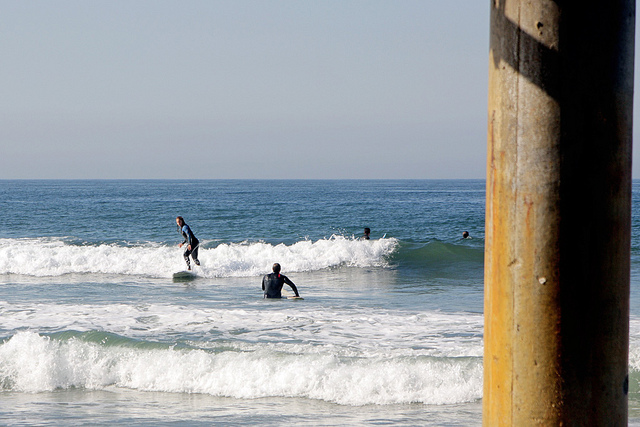

In [28]:
get_image(18472.0)

In [183]:
for k in _.keys():
    print(k.ljust(14), _[k].shape)

img_ids        torch.Size([])
img_feat       torch.Size([64, 2048])
ques           torch.Size([10, 20])
hist           torch.Size([10, 400])
ans_in         torch.Size([10, 20])
ans_out        torch.Size([10, 20])
ques_len       torch.Size([10])
hist_len       torch.Size([10])
ans_len        torch.Size([10])
num_rounds     torch.Size([])
opt            torch.Size([10, 100, 20])
opt_len        torch.Size([10, 100])
ans_ind        torch.Size([10])
gt_relevance   torch.Size([100])
round_id       torch.Size([])


In [222]:
model({
    k:v[:1] for k, v in batch.items()
})[0][0][0].argsort()

tensor([ 5,  1, 74, 55, 42, 20, 13, 70, 30, 24, 95, 61, 76, 75, 89, 81, 63, 10,
        90, 92, 22, 67, 57, 62, 49, 97, 84, 43, 99, 88, 31, 26, 29, 11, 16, 37,
        33, 80,  7, 36, 34, 86, 51, 59, 98, 17, 48,  9, 56, 60, 83, 66, 15, 52,
        91, 50,  6, 41, 38, 96, 94,  8, 93, 46, 23, 14, 68, 77, 64, 69, 27, 65,
        82, 25, 85, 78,  0, 40, 72, 53, 39, 32, 87, 71, 73, 45, 21,  3, 12, 79,
         2, 54, 18, 44, 28, 58,  4, 19, 35, 47])

In [221]:
model(batch)[0][0][0].argsort()

tensor([ 5,  1, 74, 55, 42, 20, 13, 70, 30, 24, 95, 61, 76, 75, 89, 81, 63, 10,
        90, 92, 22, 67, 57, 62, 49, 97, 84, 43, 99, 88, 31, 26, 29, 11, 16, 37,
        33, 80,  7, 36, 34, 86, 51, 59, 98, 17, 48,  9, 56, 60, 83, 66, 15, 52,
        91, 50,  6, 41, 38, 96, 94,  8, 93, 46, 23, 14, 68, 77, 64, 69, 27, 65,
        82, 25, 85, 78,  0, 40, 72, 53, 39, 32, 87, 71, 73, 45, 21,  3, 12, 79,
         2, 54, 18, 44, 28, 58,  4, 19, 35, 47])

In [215]:
batch['img_feat'].shape

torch.Size([16, 64, 2048])

In [86]:
_['ans_ind']

tensor([20, 34, 50,  4, 80, 83, 23, 24, 71, 44])

NameError: name 'caption_vectors' is not defined

2064

NameError: name 'captions_embeddings' is not defined

In [21]:
from sklearn.metrics import pairwise_distances
captions_embeddings = np.array(caption_vectors)
caption_similarities = 1-pairwise_distances(captions_embeddings, captions_embeddings, metric='cosine')
np.fill_diagonal(caption_similarities, 0)

In [23]:
with open('data/val_bot_data.pkl', 'wb') as file:
    pickle.dump((img_ids, captions, caption_similarities), file)

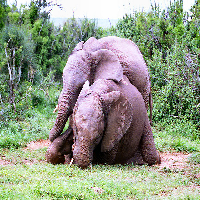

In [31]:
get_image(img_ids[300]).resize((200, 200))

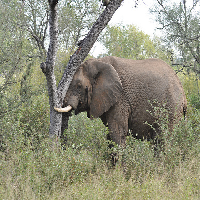

In [32]:
get_image(img_ids[caption_similarities[300, :].argmax()]).resize((200, 200))

In [96]:
img_id = float(_['img_ids'].detach().numpy())
caption_vector = (model.encoder.word_embed(_['hist'][0]).sum(0) / (_['hist'][0]!=0).sum()).detach().numpy()

In [52]:
_['hist'][0]

tensor([  54, 4155, 1628,  105,  256,  140,   35,  294,   39,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [51]:
val_dataset.vocabulary.to_words(_['hist'][0].detach().numpy())

['2',
 'polished',
 'antique',
 'cars',
 'parked',
 'next',
 'to',
 'each',
 'other',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<P

In [21]:
val_dataset[4]

{'img_ids': tensor(88394),
 'img_feat': tensor([[0.8286, 0.0000, 0.6272,  ..., 0.9962, 0.0000, 0.9970],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0224, 0.0000, 0.0737,  ..., 0.0139, 0.0318, 0.0000],
         ...,
         [0.0000, 0.0938, 0.3024,  ..., 0.0697, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'ques': tensor([[   5,    6,   59,   15,   19,    4,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [   5,   36,    7, 1038,   59,    4,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [   5,    6,  286,  116,   23,  157,    4,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [   5,    6,  177,   42,   28,  159, 2848,    4,    0,    0,    0,    0,
             0,    0,    0,    0,    0,   

In [12]:
predictions.shape

torch.Size([16, 10, 100])

In [11]:
import itertools

In [49]:
next(itertools.chain(val_dataset))

TypeError: list indices must be integers or slices, not list

In [35]:
val_dataset._pad_sequences([[0]])

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 [1])

In [ ]:
val_dataset.vocabulary.to_indices(['what', 'is', 'the', 'color', '?'])

In [120]:
val_dataset._get_history(
    caption=[2, 3 ,4],
    questions=[[7, 8], [21, 21, 22, 22, 22, 22], [1, 2]],
    answers=[[70, 80],[210, 210, 220], [1, 2]]
)

(tensor([[  2.,   3.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  2.,   3.,   4.,   7.,   8.,  70.,  80.,   2.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,

In [38]:
batch.keys()

dict_keys(['img_ids', 'img_feat', 'ques', 'hist', 'ans_in', 'ans_out', 'ques_len', 'hist_len', 'ans_len', 'num_rounds', 'opt', 'opt_len', 'ans_ind', 'gt_relevance', 'round_id'])

In [51]:
val_dataset.vocabulary.to_words(batch['ques'][2])

['<UNK>',
 '<UNK>',
 '<UNK>',
 '<UNK>',
 '<UNK>',
 '<UNK>',
 '<UNK>',
 '<UNK>',
 '<UNK>',
 '<UNK>']

In [67]:
' '.join(
    [val_dataset.vocabulary.index2word[ix] 
     for ix in batch_dict['ques'][0][1] if ix!= val_dataset.vocabulary.PAD_INDEX])

'what color is her hair ?'

In [1]:
import pickle

In [17]:
with open('data/val_data.pkl','rb') as file:
    img_ids, caption_vectors, captions, questions, questions_vectors, answers, questions = pickle.load(file)

  6%|▋         | 132/2064 [00:19<02:18, 13.92it/s]

In [1]:
# the telegram package holds everything we need for this tutorial
import telegram
from telegram.ext import Updater
from telegram.ext import CommandHandler
from telegram.ext import MessageHandler, Filters

In [2]:
TOKEN="855407001:AAEVkO06-fGF2kPKI0o1i_M2QMIqMxbm_5A"

In [3]:
bot = telegram.Bot(token=TOKEN)

In [4]:
updater = Updater(token=TOKEN, use_context=True)
# Let's create a handler function to handle when the user says "/start"
def start(update, context):
    # Here, we blindly respond to the user
    # The /start command could have come with arguments, we ignore those
    context.bot.send_message(chat_id=update.message.chat_id, text="I'm a bot, please talk to me!")

In [5]:
# A "dispatcher" object allows us to add this command handler
dispatcher = updater.dispatcher
start_handler = CommandHandler('start', start)
dispatcher.add_handler(start_handler)

In [6]:
# We have a bot, we have a command handler, let's start this thing up!
updater.start_polling()

In [7]:
# Okay, now let's respond to a user input command "caps"
def caps(update, context):
    text_caps = ' '.join(context.args).upper()
    context.bot.send_message(chat_id=update.message.chat_id, text=text_caps)

caps_handler = CommandHandler('caps', caps)
dispatcher.add_handler(caps_handler)